# CNN   small datasets 학습


- Data의 수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 feature를 찾을 수 있는데 있음 
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 이미지의 색깔, 각도 등을 약간씩 변형하여 data의 수를 늘림 
    - Pre-trained network의 활용
        - 매우 큰 데이터셋으로 미리 Training한 모델의 파라미터(가중치)를 가져와서 풀려는 문제에 맞게 모델을 재보정해서 사용하는 것.
        - 미리 다양한 데이터를 가지고 학습된 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 학습: 2000, 검증: 1000, 테스트: 1000
    
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

- gdown 패키지 : 구글 드라이브의 공유파일 다운로드 패키지    
- `pip install gdown==3.3.1`
- 코랩에는 설치 되어 있음.

In [ ]:
!pip install gdown==3.3.1

In [ ]:
# 이미지 다운로드
import gdown

url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
fname = 'cats_and_dogs_small.zip'

gdown.download(url, fname, quiet=False) #구글드라이브에 url 로 공유된 파일을 ,다운로드. 다운로드된 파일의 이름을 fname으로 저장.

Downloading...
From: https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU
To: /content/cats_and_dogs_small.zip
90.8MB [00:00, 149MB/s]


'cats_and_dogs_small.zip'

In [ ]:
# 디렉토리 생성
!mkdir data

In [ ]:
# data디렉토리 밑에 압축풀기
!unzip -q cats_and_dogs_small.zip -d data

In [ ]:
# !rm -r data

# ImageDataGenerator 생성

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# 하이퍼파라미터 정의

In [ ]:
LEARN_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 32

IMAGE_SIZE = 224

In [ ]:
train_dir = "/content/data/train"
valid_dir = "/content/data/validation"
test_dir = "/content/data/test"

In [ ]:
# ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
# raw data 연결
# 디렉토리 확인만 하는 개념. 실제 데이터를 디스크에서 메모리로 읽지 않는다.
#   (iterator로 부터 데이터를 요청할 때 읽어들인다.=>학습)
train_iter = train_datagen.flow_from_directory(train_dir, #image  경로
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), # 리사이즈 크기
                                               class_mode='binary', #output 형태
                                               batch_size=N_BATCHS #미니배치 사이즈
                                               )

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                              class_mode='binary', batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# LABEL 확인 - Iterator.class_indices
train_iter.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
# 1 에폭당 step 수 - len(iterator)
len(train_iter), len(valid_iter), len(test_iter)

(63, 32, 32)

In [ ]:
# iterator를 이용해서 데이터 조회
batch = next(train_iter) #batch_size 개수만큼 조회
print(type(batch)) #0: X-이미지데이터, 1: Y-label
print(type(batch[0]), type(batch[1]))
print(batch[0].shape, batch[1].shape)

<class 'tuple'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(32, 224, 224, 3) (32,)


In [ ]:
batch[1][:10]

array([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
import numpy as np
np.min(batch[0][0]), np.max(batch[0][0])

(0.0, 1.0)

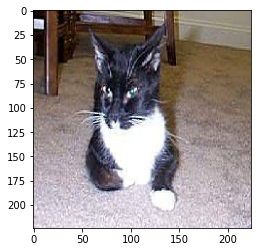

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(batch[0][0])
plt.show()

## Build a network

- Input: $224 \times 224$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification) 
- ImageDataGenerator를 이용해 파일시스템에 저장된 이미지데이터셋을 학습시킨다.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

import numpy as np

In [ ]:
def create_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(layers.MaxPool2D(padding="same"))

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    # Dense
    model.add(layers.Flatten())
    # dropout
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(units=512, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid')) #2진 분류 출력 레이어

    return model

In [ ]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARN_RATE), 
              loss='binary_crossentropy',  #2진분류
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)      

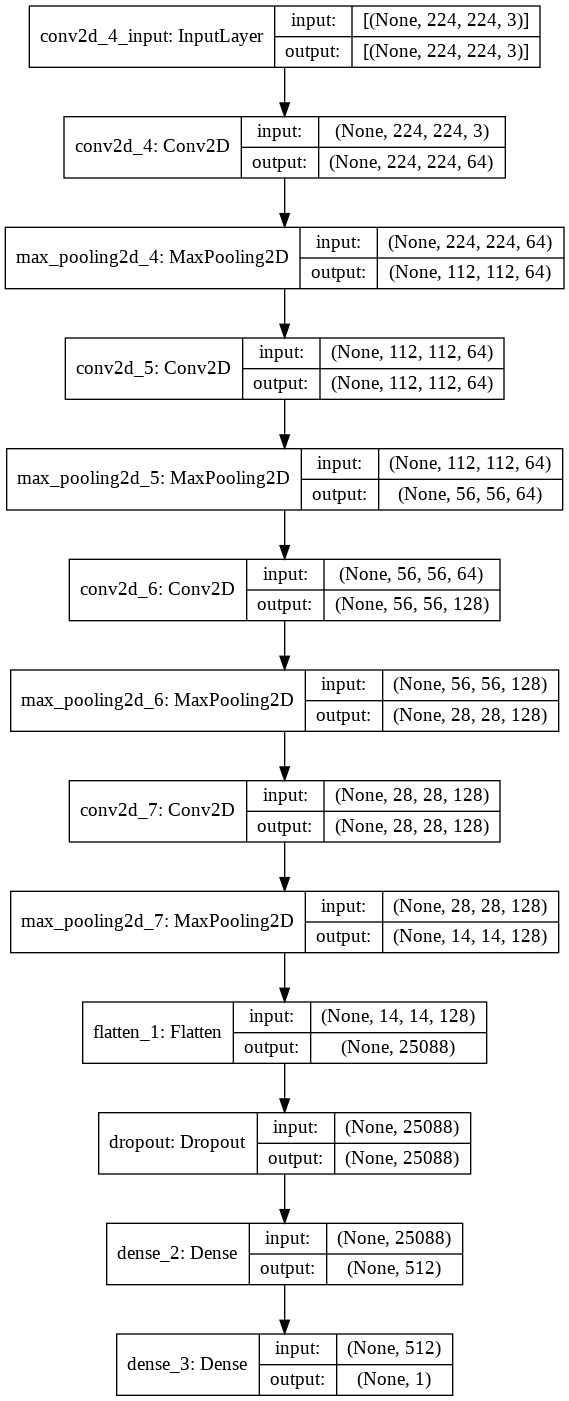

In [ ]:
keras.utils.plot_model(model, show_shapes=True)


##  Model Training(학습)

In [ ]:
import os
save_dir = os.path.join("/content/drive/MyDrive/deeplearning", "cat_dog_model", "basic")
print(save_dir)
os.makedirs(save_dir, exist_ok=True)

/content/drive/MyDrive/deeplearning/cat_dog_model/basic


In [ ]:
save_file_path = os.path.join(save_dir, "weights_ckpt")  #저장할 weight 파일경로

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True, 
                                              save_best_only=True, 
                                              monitor='val_loss', 
                                              verbose=2)

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            patience=10)

In [ ]:
# train dataset => ImageDataGenerator 를 지정 (iterator)
# steps_per_epoch : 1에폭당 몇 step인지.
hist = model.fit(train_iter, epochs=N_EPOCHS, 
                 steps_per_epoch=len(train_iter),
                 validation_data=valid_iter, 
                 validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
63/63 [==============================] - 14s 218ms/step - loss: 0.7263 - accuracy: 0.5030 - val_loss: 0.6926 - val_accuracy: 0.5030

Epoch 00001: val_loss improved from inf to 0.69263, saving model to /content/drive/MyDrive/deeplearning/cat_dog_model/basic/weights_ckpt
Epoch 2/100
63/63 [==============================] - 14s 218ms/step - loss: 0.6939 - accuracy: 0.5210 - val_loss: 0.6856 - val_accuracy: 0.5850

Epoch 00002: val_loss improved from 0.69263 to 0.68559, saving model to /content/drive/MyDrive/deeplearning/cat_dog_model/basic/weights_ckpt
Epoch 3/100
63/63 [==============================] - 14s 218ms/step - loss: 0.6899 - accuracy: 0.5545 - val_loss: 0.6758 - val_accuracy: 0.6020

Epoch 00003: val_loss improved from 0.68559 to 0.67584, saving model to /content/drive/MyDrive/deeplearning/cat_dog_model/basic/weights_ckpt
Epoch 4/100
63/63 [==============================] - 14s 219ms/step - loss: 0.6805 - accuracy: 0.5745 - val_loss: 0.7032 - val_accuracy: 0.5880

E

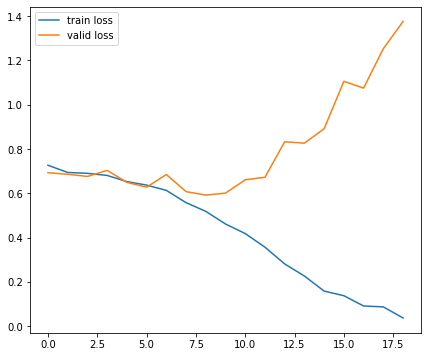

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='valid loss')
plt.legend()
plt.show()

In [ ]:
# 저장된 모델 조회
save_model = create_model()
save_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARN_RATE), 
                    loss='binary_crossentropy',  #2진분류
                    metrics=['accuracy'])

In [ ]:
save_model.evaluate(test_iter)

32/32 [==============================] - 4s 122ms/step - loss: 0.6931 - accuracy: 0.5040


[0.6931053996086121, 0.5040000081062317]

In [ ]:
# 학습된 weight로 업데이트
save_model.load_weights(save_file_path)

In [ ]:
save_model.evaluate(test_iter)

32/32 [==============================] - 4s 121ms/step - loss: 0.5944 - accuracy: 0.6780


[0.594409704208374, 0.6779999732971191]

# 새로운 데이터 추론

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_preprocess_image(img_path):
    """
    img_path 이미지를 읽어서 추론할 수있는 ndarray로 변환해서 반환하는 함수
    """
    #PILLOW 이미지 객체.224,224로 리사이즈해서 읽어온다.
    raw_img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) 
    img_array = img_to_array(raw_img) #Pillow -> ndarray 
    img_array = img_array[np.newaxis, ...] #batch 축(0축)을 생성
    return (img_array/255.0).astype(np.float32)


In [ ]:
dog = load_preprocess_image('dog.jpg')
cat = load_preprocess_image('cat.jpg')
dog.shape, cat.shape

((1, 224, 224, 3), (1, 224, 224, 3))

In [ ]:
pred1 = save_model.predict(dog)
pred2 = save_model.predict(cat)

In [ ]:
print(pred1)
result1 = np.where(pred1>0.5, 1, 0)[0]
result1

[[0.75001186]]


array([1])

In [ ]:
print(pred2)
result2 = np.where(pred2>0.5, 1, 0)[0]
result2


[[0.22432068]]


array([0])

In [ ]:
train_iter.class_indices

{'cats': 0, 'dogs': 1}

# Using data augmentation

- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로부터 그럴듯하게 이미지 변환을 통해서 이미지(데이터)를 늘리는 작업을 Image augmentation
- train_set에만 적용, validation, test set에는 적용하지 않는다. (rescaling만 한다.)

In [ ]:
# ImageDataGenerator에 Image Augmentation 기능을 추가 해서 생성
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
# 하이파러파미터
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 80

IMAGE_SIZE = 224

In [ ]:
# ImageDataGenerator 생성
# Raw data 경로 설정
train_dir = '/content/data/train'
valid_dir = '/content/data/validation'
test_dir = '/content/data/test'

In [ ]:
# train에만 Image Augmentation 을 적용. validation/test는 적용하지 않는다.
train_datagen = ImageDataGenerator(rescale=1/255.0, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, #실수 0 ~ 1 - 비율, 정수: 픽셀
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   fill_mode='constant'
                                   )

valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)


In [ ]:
train_iter = train_datagen.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                class_mode='binary', batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# train 이미지들을 확인
batch_samples = next(train_iter)
len(batch_samples) #0: 이미지, 1: label

NameError: ignored

In [ ]:
batch_image_sample = batch_samples[0]
batch_image_sample.shape, batch_image_sample.dtype

((80, 224, 224, 3), dtype('float32'))

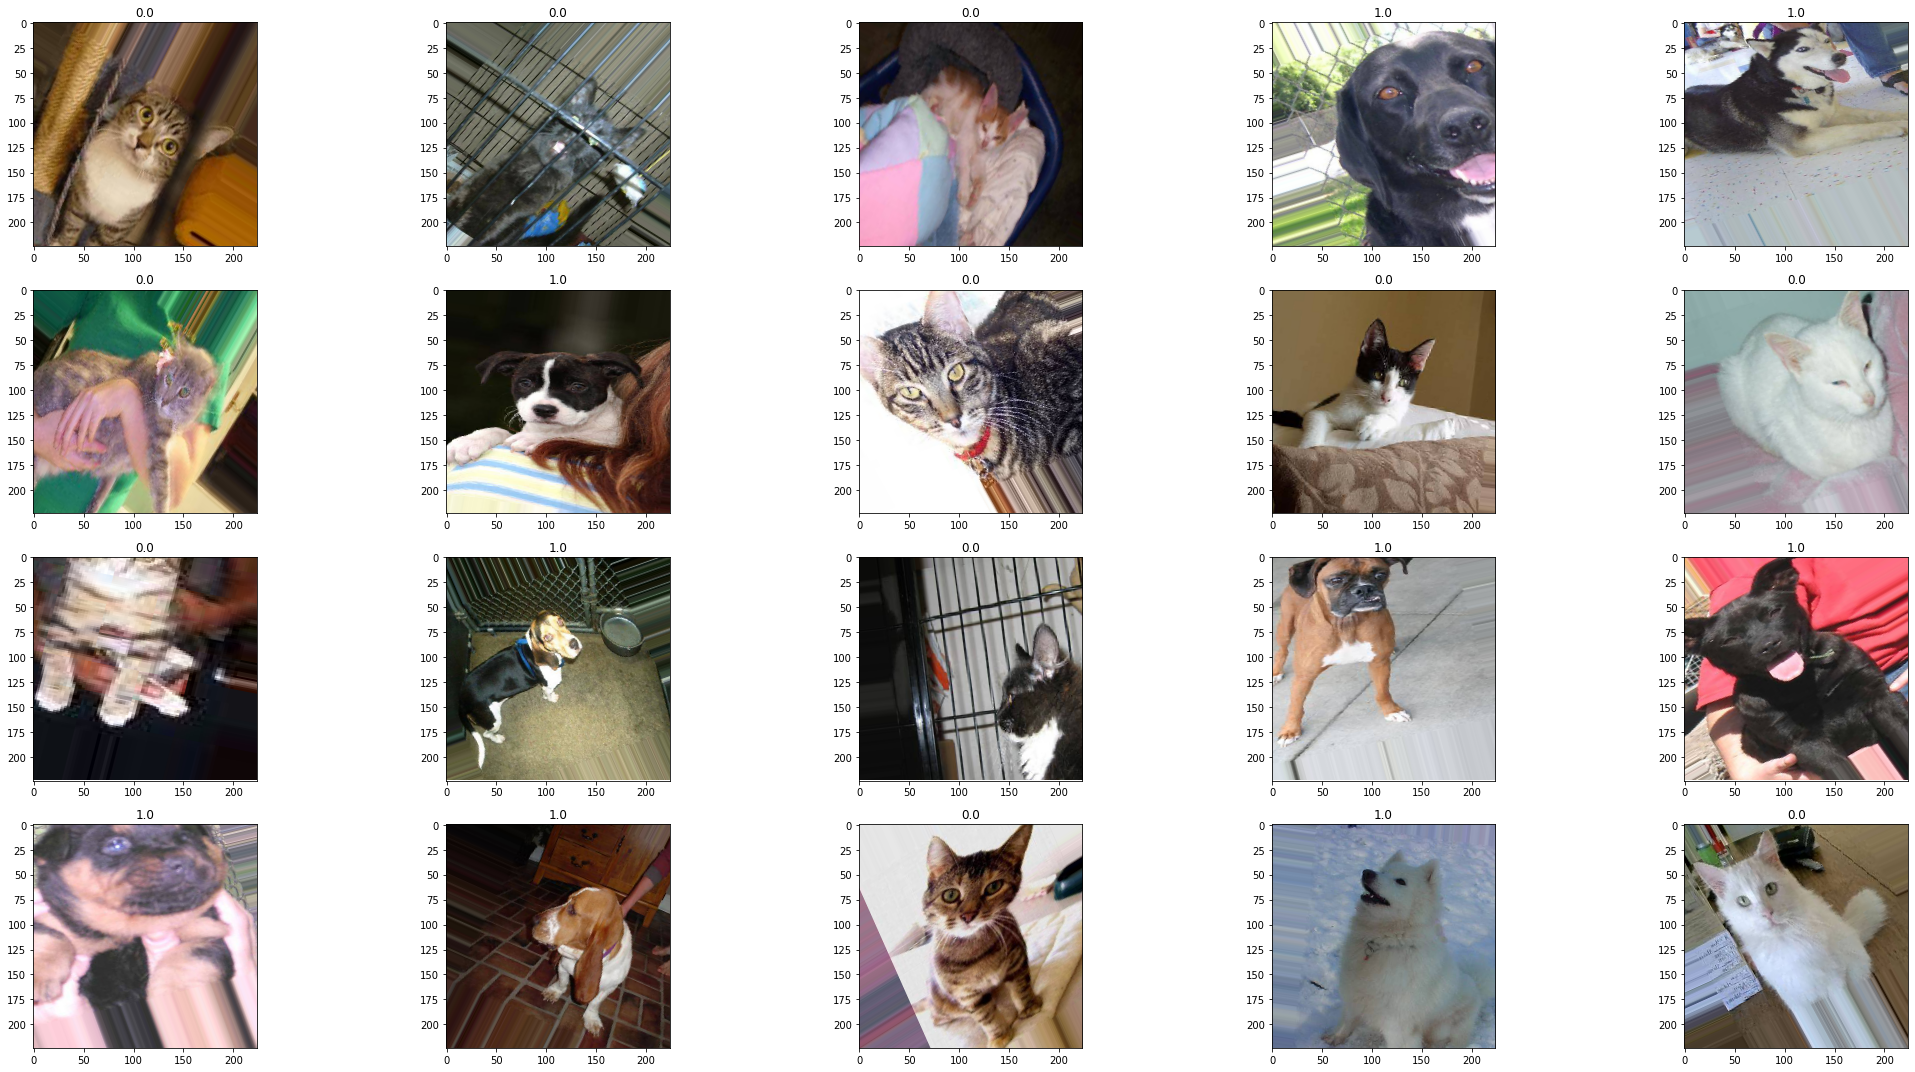

In [ ]:
plt.figure(figsize=(30,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(batch_image_sample[i].astype('uint8'))
    plt.title(str(batch_samples[1][i]))

plt.tight_layout()
plt.show()

In [ ]:
# 모델 생성
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# 학습
save_dir = os.path.join("/content/drive/MyDrive/deeplearning/cat_dog_model", "augmentation")
os.makedirs(save_dir, exist_ok=True)

In [ ]:
save_file_path = os.path.join(save_dir, 'weights_ckpt')

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True, 
                                              save_best_only=True, 
                                              monitor='val_loss', 
                                              verbose=2)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)

In [ ]:
hist = model.fit(train_iter, epochs=N_EPOCHS, steps_per_epoch=len(train_iter), 
                 validation_data=valid_iter, validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
25/25 [==============================] - 30s 1s/step - loss: 0.7111 - accuracy: 0.5165 - val_loss: 0.7058 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.70580, saving model to /content/drive/MyDrive/deeplearning/cat_dog_model/augmentation/weights_ckpt
Epoch 2/100
25/25 [==============================] - 30s 1s/step - loss: 0.6921 - accuracy: 0.5085 - val_loss: 0.6869 - val_accuracy: 0.6130

Epoch 00002: val_loss improved from 0.70580 to 0.68686, saving model to /content/drive/MyDrive/deeplearning/cat_dog_model/augmentation/weights_ckpt
Epoch 3/100
25/25 [==============================] - 30s 1s/step - loss: 0.6938 - accuracy: 0.5305 - val_loss: 0.6924 - val_accuracy: 0.5070

Epoch 00003: val_loss did not improve from 0.68686
Epoch 4/100
25/25 [==============================] - 29s 1s/step - loss: 0.6901 - accuracy: 0.5285 - val_loss: 0.6848 - val_accuracy: 0.5830

Epoch 00004: val_loss improved from 0.68686 to 0.68484, saving model to /content/drive/My

In [ ]:
saved_model_aug = create_model()
saved_model_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# 저장된 weight를 불러오기
save_file_path = '/content/drive/MyDrive/deeplearning/cat_dog_model/augmentation/weights_ckpt'
saved_model_aug.load_weights(save_file_path)

In [ ]:
saved_model_aug.evaluate(test_iter)

13/13 [==============================] - 47s 3s/step - loss: 0.4708 - accuracy: 0.7900


[0.47084373235702515, 0.7900000214576721]

In [ ]:
# 새로운데이터 추론

In [ ]:
dog2 = load_preprocess_image('dog.jpg')
cat2 = load_preprocess_image('cat.jpg')

pred3 = saved_model_aug.predict(dog2)
pred4 = saved_model_aug.predict(cat2)

In [ ]:
pred3

array([[0.9507083]], dtype=float32)

In [ ]:
pred4

array([[0.13081592]], dtype=float32)

###  DataFrame 이용
- flow_from_dataframe() 사용
    - 파일경로와 label을 DataFrame으로 저장하고 그것을 이용해 데이터셋을 읽어온다.

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=17ejPJw42TgTv0jCPMMlVTHwF57XYE2kb'
fname = 'cats_and_dogs_union.zip'
gdown.download(url, fname, quiet=True)

'cats_and_dogs_union.zip'

In [ ]:
!unzip cats_and_dogs_union.zip -d data/union

Archive:  cats_and_dogs_union.zip
   creating: data/union/cats/
  inflating: data/union/cats/cat.0.jpg  
  inflating: data/union/cats/cat.1.jpg  
  inflating: data/union/cats/cat.10.jpg  
  inflating: data/union/cats/cat.100.jpg  
  inflating: data/union/cats/cat.1000.jpg  
  inflating: data/union/cats/cat.1001.jpg  
  inflating: data/union/cats/cat.1002.jpg  
  inflating: data/union/cats/cat.1003.jpg  
  inflating: data/union/cats/cat.1004.jpg  
  inflating: data/union/cats/cat.1005.jpg  
  inflating: data/union/cats/cat.1006.jpg  
  inflating: data/union/cats/cat.1007.jpg  
  inflating: data/union/cats/cat.1008.jpg  
  inflating: data/union/cats/cat.1009.jpg  
  inflating: data/union/cats/cat.101.jpg  
  inflating: data/union/cats/cat.1010.jpg  
  inflating: data/union/cats/cat.1011.jpg  
  inflating: data/union/cats/cat.1012.jpg  
  inflating: data/union/cats/cat.1013.jpg  
  inflating: data/union/cats/cat.1014.jpg  
  inflating: data/union/cats/cat.1015.jpg  
  inflating: data/unio

In [ ]:
# glob - 파일경로를 (문자열)조회 라이브러리
from glob import glob
# glob(경로) : 지정한 경로를 문자열로 반환.
# ** 모든 하위디렉토리.  *: 모든것.
# glob('/content/data/union/cats/*') #/content/data/union/cats/ 디렉토리 아래있는 모든 것(파일/디렉토리)들의 경로를 반환
# glob('/content/data/union/cats/*.jpg') #  *.jpg 파일들의 경로만 반환
# glob('/content/data/union/cats/a*.jpg') #a로 시작하고 확장자가 jpg인 파일들의 경로를 반환

[]

In [ ]:
# glob('/content/data/union/cats/*')
# glob('/content/data/union/dogs/*')
r=glob('/content/data/union/**/*.jpg')  #union의 모든 하위디렉토리에 있는 확장자가 jpg인 파일들의 경로를 반환
len(r)

4000

In [ ]:
r[:10]

['/content/data/union/cats/cat.1622.jpg',
 '/content/data/union/cats/cat.884.jpg',
 '/content/data/union/cats/cat.249.jpg',
 '/content/data/union/cats/cat.1456.jpg',
 '/content/data/union/cats/cat.1209.jpg',
 '/content/data/union/cats/cat.340.jpg',
 '/content/data/union/cats/cat.409.jpg',
 '/content/data/union/cats/cat.1021.jpg',
 '/content/data/union/cats/cat.458.jpg',
 '/content/data/union/cats/cat.1435.jpg']

In [ ]:
r[-10:]

['/content/data/union/dogs/dog.235.jpg',
 '/content/data/union/dogs/dog.1184.jpg',
 '/content/data/union/dogs/dog.1621.jpg',
 '/content/data/union/dogs/dog.918.jpg',
 '/content/data/union/dogs/dog.1290.jpg',
 '/content/data/union/dogs/dog.734.jpg',
 '/content/data/union/dogs/dog.1910.jpg',
 '/content/data/union/dogs/dog.3.jpg',
 '/content/data/union/dogs/dog.1460.jpg',
 '/content/data/union/dogs/dog.1168.jpg']

In [ ]:
# 파일명에서 라벨만 추출
f = '/content/data/union/cats/cat.1622.jpg' # 디렉토리/파일명 
f.split('.')

['/content/data/union/cats/cat', '1622', 'jpg']

In [ ]:
import os
print(os.path.basename(f)) #경로에서 마지막 경로만 추출 (디렉토리1/디렉토리2/파일명)
print(os.path.dirname(f)) # 경로에서 디렉토리만 추출

cat.1622.jpg
/content/data/union/cats


In [ ]:
os.path.basename(f).split('.')[0]

'cat'

In [ ]:
os.path.dirname(f).split('/')[4]

'cats'

# 파일경로와 Label 정의한 DataFrame 생성
- 두 개컬럼 (파일경로-path, 라벨-label)

In [ ]:
from glob import glob
path_list = glob('/content/data/union/**/*.jpg')
type(path_list)

list

In [ ]:
# label_list
label_list = []
for path in path_list:
    label = os.path.basename(path).split('.')[0]
    label_list.append(label)

In [ ]:
label_list[-10:]

['dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog']

In [ ]:
# List comprehension이용
label_list2 = [os.path.basename(path).split('.')[0] for path in path_list]
label_list2[:10]

['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']

In [ ]:
import pandas as pd
d = {
    'path':path_list,  #컬럼명:value리스트
    'label':label_list
}
df = pd.DataFrame(d)
df.shape

(4000, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    4000 non-null   object
 1   label   4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB


In [ ]:
df.describe()

,path,label
count,4000,4000
unique,4000,2
top,/content/data/union/dogs/dog.598.jpg,dog
freq,1,2000


In [ ]:
df['label'].value_counts()

dog    2000
cat    2000
Name: label, dtype: int64

In [ ]:
df.head()

,path,label
0,/content/data/union/cats/cat.1622.jpg,cat
1,/content/data/union/cats/cat.884.jpg,cat
2,/content/data/union/cats/cat.249.jpg,cat
3,/content/data/union/cats/cat.1456.jpg,cat
4,/content/data/union/cats/cat.1209.jpg,cat


In [ ]:
df.tail()

,path,label
3995,/content/data/union/dogs/dog.734.jpg,dog
3996,/content/data/union/dogs/dog.1910.jpg,dog
3997,/content/data/union/dogs/dog.3.jpg,dog
3998,/content/data/union/dogs/dog.1460.jpg,dog
3999,/content/data/union/dogs/dog.1168.jpg,dog


In [ ]:
# 파일로 저장
df.to_csv('cat_dog_path.cvs', index=False)

# train/test/validation set으로 나누기.

In [ ]:
# cat경로, dog경로 를 가지는 dataframe을 나누기.
cat_df = df[df['label']=='cat']

dog_df = df[df['label']=='dog']
cat_df.shape, dog_df.shape

((2000, 2), (2000, 2))

In [ ]:
cat_df['label'].value_counts()
dog_df['label'].value_counts()

dog    2000
Name: label, dtype: int64

In [ ]:
# train/test=8:2
idx = 1600
train_df = pd.concat([cat_df.iloc[:idx], dog_df.iloc[:idx]], axis=0)

test_df = pd.concat([cat_df.iloc[idx:], dog_df.iloc[idx:]], axis=0)

train_df.shape, test_df.shape

((3200, 2), (800, 2))

In [ ]:
train_df['label'].value_counts()

dog    1600
cat    1600
Name: label, dtype: int64

In [ ]:
test_df['label'].value_counts()

dog    400
cat    400
Name: label, dtype: int64

# ImageDataGenerator 생성

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.0, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   brightness_range=[0.7, 1.3],
                                   fill_mode='constant')

valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
# DataFrame을 이용해서 raw data를 설정
train_iter = train_datagen.flow_from_dataframe(train_df, # 경로, 라벨을 가진 Dataframe
                                               x_col="path", #경로 컬럼명
                                               y_col='label', #Label 컬럼명
                                               class_mode='binary',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               batch_size=N_BATCHS
                                               )

valid_iter = valid_datagen.flow_from_dataframe(test_df,
                                               x_col="path", #경로 컬럼명
                                               y_col='label', #Label 컬럼명
                                               class_mode='binary',
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               batch_size=N_BATCHS)

Found 3200 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [ ]:
train_iter.class_indices

{'cat': 0, 'dog': 1}

In [ ]:
# 모델 생성, 컴파일
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit(train_iter, epochs=1, steps_per_epoch=len(train_iter), 
                 validation_data=valid_iter, validation_steps=len(valid_iter))

40/40 [==============================] - 660s 16s/step - loss: 0.7006 - accuracy: 0.5094 - val_loss: 0.6921 - val_accuracy: 0.5150
